# V(D)J clustering

On the topic of finding clones/clonotypes, there are many ways used for clustering BCRs, almost all involving some measure based on sequence similarity. There are also a lot of very well established guidelines and criterias maintained by the BCR community. For example, *immcantation* uses a number of model-based [methods](https://changeo.readthedocs.io/en/stable/methods/clustering.html) [[Gupta2015]](https://academic.oup.com/bioinformatics/article/31/20/3356/195677) to group clones based on the distribution of length-normalised junctional hamming distance while others use the whole BCR V(D)J sequence to define clones as shown in this paper [[Bashford-Rogers2019]](https://www.nature.com/articles/s41586-019-1595-3).

<b>Import modules</b>

In [1]:
import os
import dandelion as ddl

ddl.logging.print_header()

dandelion==0.4.1.dev13 pandas==2.2.3 numpy==2.0.2 matplotlib==3.8.4 networkx==3.4.2 scipy==1.14.1


In [2]:
# change directory to somewhere more workable
os.chdir(os.path.expanduser("~/Downloads/dandelion_tutorial/"))
# I'm importing scanpy here to make use of its logging module.
import scanpy as sc

sc.settings.verbosity = 3
import warnings

warnings.filterwarnings("ignore")
sc.logging.print_header()

scanpy==1.10.3 anndata==0.10.9 umap==0.5.6 numpy==2.0.2 scipy==1.14.1 pandas==2.2.3 scikit-learn==1.5.0 statsmodels==0.14.2 igraph==0.11.6 pynndescent==0.5.13


<b>Read in the previously saved files</b>

I will work with the same example from the previous section since I have the filtered V(D)J data stored in a `Dandelion` class.

In [3]:
vdj = ddl.read_h5ddl("dandelion_results.h5ddl")
vdj

Dandelion class object with n_obs = 2234 and n_contigs = 7357
    data: 'sequence_id', 'sequence', 'rev_comp', 'productive', 'v_call', 'd_call', 'j_call', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'v_cigar', 'd_cigar', 'j_cigar', 'stop_codon', 'vj_in_frame', 'locus', 'c_call', 'junction_length', 'np1_length', 'np2_length', 'v_sequence_start', 'v_sequence_end', 'v_germline_start', 'v_germline_end', 'd_sequence_start', 'd_sequence_end', 'd_germline_start', 'd_germline_end', 'j_sequence_start', 'j_sequence_end', 'j_germline_start', 'j_germline_end', 'v_score', 'v_identity', 'v_support', 'd_score', 'd_identity', 'd_support', 'j_score', 'j_identity', 'j_support', 'fwr1', 'fwr2', 'fwr3', 'fwr4', 'cdr1', 'cdr2', 'cdr3', 'cell_id', 'consensus_count', 'umi_count', 'v_call_10x', 'd_call_10x', 'j_call_10x', 'junction_10x', 'junction_10x_aa', 'j_support_igblastn', 'j_score_igblastn', 'j_call_igblastn', 'j_call_blastn', 'j_identity_blastn', 'j_alignment_length_blastn', 

## Finding clones

The following is *dandelion*'s implementation of a rather conventional method to define clones, `ddl.tl.find_clones`. 

<div class="alert alert-info">

Clone definition criterion
    
<b>Clone definition is based on the following criterion:</b><br><br>

<b>I.</b> Identical V- and J-gene usage in the VDJ chain (IGH/TRB/TRD).<br><br>

<b>II.</b> Identical CDR3 junctional/CDR3 sequence length in the VDJ chain.<br><br>

<b>III.</b> VDJ chain junctional/CDR3 sequences attains a minimum of % sequence similarity, based on hamming distance. The similarity cut-off is tunable (default is 85%; change to 100% if analyzing TCR data).<br><br>

<b>IV.</b> VJ chain (IGK/IGL/TRA/TRG) usage. If cells within clones use different VJ chains, the clone will be split following the same conditions for VDJ chains in (1-3) as above.
</div>

### (Optional) Simplifying annotation calls.
This is an optional step to simplify the annotation calls. The `vdj.simplify()` will reduce the complexity of the gene names and strip the alleles. This impacts on how clones are defined (using simpler v/j calls) and also visualiation.

In [4]:
# original
vdj.data[["v_call_genotyped", "j_call", "c_call"]]

,v_call_genotyped,j_call,c_call
sequence_id,,,
sc5p_v2_hs_PBMC_10k_AAACCTGTCATATCGG_contig_1,"IGKV1-33*01,IGKV1D-33*01",IGKJ4*01,IGKC
sc5p_v2_hs_PBMC_10k_AAACCTGTCCGTTGTC_contig_2,"IGHV1-69*01,IGHV1-69D*01",IGHJ3*02,IGHM
sc5p_v2_hs_PBMC_10k_AAACCTGTCCGTTGTC_contig_1,IGKV1-8*01,IGKJ1*01,IGKC
sc5p_v2_hs_PBMC_10k_AAACCTGTCGAGAACG_contig_1,IGLV5-45*02,IGLJ3*02,IGLC3
sc5p_v2_hs_PBMC_10k_AAACCTGTCGAGAACG_contig_2,IGHV1-2*02,IGHJ3*02,IGHM
...,...,...,...
vdj_v1_hs_pbmc3_TTTCCTCTCGACAGCC_contig_1,IGHV1-46*01,IGHJ5*02,IGHM
vdj_v1_hs_pbmc3_TTTGCGCCATACCATG_contig_2,"IGHV1-69*01,IGHV1-69D*01",IGHJ6*02,IGHM
vdj_v1_hs_pbmc3_TTTGCGCCATACCATG_contig_1,IGLV1-47*01,IGLJ3*02,IGLC3


In [5]:
vdj.simplify()
vdj.data[["v_call_genotyped", "j_call", "c_call"]]

,v_call_genotyped,j_call,c_call
sequence_id,,,
sc5p_v2_hs_PBMC_10k_AAACCTGTCATATCGG_contig_1,IGKV1-33,IGKJ4,IGKC
sc5p_v2_hs_PBMC_10k_AAACCTGTCCGTTGTC_contig_2,IGHV1-69,IGHJ3,IGHM
sc5p_v2_hs_PBMC_10k_AAACCTGTCCGTTGTC_contig_1,IGKV1-8,IGKJ1,IGKC
sc5p_v2_hs_PBMC_10k_AAACCTGTCGAGAACG_contig_1,IGLV5-45,IGLJ3,IGLC3
sc5p_v2_hs_PBMC_10k_AAACCTGTCGAGAACG_contig_2,IGHV1-2,IGHJ3,IGHM
...,...,...,...
vdj_v1_hs_pbmc3_TTTCCTCTCGACAGCC_contig_1,IGHV1-46,IGHJ5,IGHM
vdj_v1_hs_pbmc3_TTTGCGCCATACCATG_contig_2,IGHV1-69,IGHJ6,IGHM
vdj_v1_hs_pbmc3_TTTGCGCCATACCATG_contig_1,IGLV1-47,IGLJ3,IGLC3


### Running `ddl.tl.find_clones`
The function will take a file path, a pandas `DataFrame` (for example if you've used pandas to read in the filtered file already), or a `Dandelion` class object. The default mode for calculation of junctional hamming distance is to use the CDR3 junction amino acid sequences, specified via the `key` option (`None` defaults to `junction_aa`). You can switch it to using CDR3 junction nucleotide sequences (`key = 'junction'`), or even the full V(D)J amino acid sequence (`key = 'sequence_alignment_aa'`), as long as the column name exists in the `.data` slot.

Clustering TCR is possible with the same setup but requires changing of default parameters (covered in the TCR section).

In [6]:
ddl.tl.find_clones(vdj)
vdj

Finding clonotypes


Finding clones based on B cell VJ chains : 100%|██████████| 203/203 [00:00<00:00, 5234.11it/s]
Refining clone assignment based on VJ chain pairing : 100%|██████████| 2234/2234 [00:00<00:00, 550080.73it/s]


 finished: Updated Dandelion object: 
   'data', contig-indexed AIRR table
   'metadata', cell-indexed observations table
 (0:00:00)


Dandelion class object with n_obs = 2234 and n_contigs = 7357
    data: 'sequence_id', 'sequence', 'rev_comp', 'productive', 'v_call', 'd_call', 'j_call', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'v_cigar', 'd_cigar', 'j_cigar', 'stop_codon', 'vj_in_frame', 'locus', 'c_call', 'junction_length', 'np1_length', 'np2_length', 'v_sequence_start', 'v_sequence_end', 'v_germline_start', 'v_germline_end', 'd_sequence_start', 'd_sequence_end', 'd_germline_start', 'd_germline_end', 'j_sequence_start', 'j_sequence_end', 'j_germline_start', 'j_germline_end', 'v_score', 'v_identity', 'v_support', 'd_score', 'd_identity', 'd_support', 'j_score', 'j_identity', 'j_support', 'fwr1', 'fwr2', 'fwr3', 'fwr4', 'cdr1', 'cdr2', 'cdr3', 'cell_id', 'consensus_count', 'umi_count', 'v_call_10x', 'd_call_10x', 'j_call_10x', 'junction_10x', 'junction_10x_aa', 'j_support_igblastn', 'j_score_igblastn', 'j_call_igblastn', 'j_call_blastn', 'j_identity_blastn', 'j_alignment_length_blastn', 

This will return a new column with the column name `'clone_id'` as per convention. If a file path is provided as input, it will also save the file automatically into the base directory of the file name. Otherwise, a `Dandelion` object will be returned.

<div class="alert alert-info">

Clonotype definition criterion

The `clone_id` follows an `A_B_C_D_E_F` format and largely reflects the conditions above where:

    {A} indicates if the contigs use the same V and J genes in the VDJ chain.
    
    {B} indicates if junctional/CDR3 sequences are equal in length in the VDJ chain.
    
    {C} indicates if clones are split based on junctional/CDR3 hamming distance threshold (for VDJ chain).
    
    {D} indicates if the contigs use the same V and J genes in the VJ chain.
    
    {E} indicates if junctional/CDR3 sequences are equal in length in the VJ chain.
    
    {F} indicates if clones are split based on junctional/CDR3 hamming distance threshold (for VJ chain).

</div>

Also, to prevent issues with clonotype ids matching between B cells and T cells, there will be a prefix added to the `clone_id` to reflect whether or not it's a `B`, `abT` or `gdT` clone.

Also, to reduce ambiguity, the `A_B_C` segment will have the `VDJ` prefix and the `D_E_F` segment will have the `VJ` suffix.

Therefor, a complete B cell clonotype id will look something like:

`B_VDJ_1_1_2_VJ_2_1_1`

For an `Orphan VDJ`, it would be `B_VDJ_1_1_2`.

For an `Orphan VJ`, it would be `B_VJ_2_1_1`.

There is also an alternate column called `clone_id_by_size` which is a simple numerical version of the `clone_id` which corresponds to the size of the clonotype - `1` is the largest clonotype, `2` is the second largest, and so on.

In [7]:
vdj.metadata

,clone_id,clone_id_by_size,sample_id,locus_VDJ,locus_VJ,productive_VDJ,productive_VJ,v_call_genotyped_VDJ,d_call_VDJ,j_call_VDJ,...,d_call_B_VDJ_main,j_call_B_VDJ_main,v_call_B_VJ_main,j_call_B_VJ_main,isotype,isotype_status,locus_status,chain_status,rearrangement_status_VDJ,rearrangement_status_VJ
sc5p_v2_hs_PBMC_10k_AAACCTGTCATATCGG,B_VJ_81_2_8,99,sc5p_v2_hs_PBMC_10k,None,IGK,None,T,None,None,None,...,None,None,IGKV1-33,IGKJ4,,,Orphan IGK,Orphan VJ,None,standard
sc5p_v2_hs_PBMC_10k_AAACCTGTCCGTTGTC,B_VDJ_172_4_2_VJ_166_2_3,1988,sc5p_v2_hs_PBMC_10k,IGH,IGK,T,T,IGHV1-69,IGHD3-22,IGHJ3,...,IGHD3-22,IGHJ3,IGKV1-8,IGKJ1,IgM,IgM,IGH + IGK,Single pair,standard,standard
sc5p_v2_hs_PBMC_10k_AAACCTGTCGAGAACG,B_VDJ_202_1_1_VJ_92_1_1,1602,sc5p_v2_hs_PBMC_10k,IGH,IGL,T,T,IGHV1-2,None,IGHJ3,...,None,IGHJ3,IGLV5-45,IGLJ3,IgM,IgM,IGH + IGL,Single pair,standard,standard
sc5p_v2_hs_PBMC_10k_AAACCTGTCTTGAGAC,B_VDJ_103_4_4_VJ_154_1_1,1603,sc5p_v2_hs_PBMC_10k,IGH,IGK,T,T,IGHV5-51,None,IGHJ3,...,None,IGHJ3,IGKV1D-8,IGKJ2,IgM,IgM,IGH + IGK,Single pair,standard,standard
sc5p_v2_hs_PBMC_10k_AAACGGGAGCGACGTA,B_VDJ_63_2_1_VJ_145_2_7,1604,sc5p_v2_hs_PBMC_10k,IGH,IGL,T,T,IGHV4-4,IGHD6-13,IGHJ3,...,IGHD6-13,IGHJ3,IGLV3-19,IGLJ2,IgM,IgM,IGH + IGL,Single pair,standard,standard
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
vdj_v1_hs_pbmc3_TTTCCTCAGCAATATG,B_VDJ_32_1_1_VJ_79_2_8,812,vdj_v1_hs_pbmc3,IGH,IGK,T,T,IGHV2-5,IGHD5/OR15-5a,IGHJ4,...,IGHD5/OR15-5a,IGHJ4,IGKV4-1,IGKJ4,IgM,IgM,IGH + IGK,Single pair,standard,standard
vdj_v1_hs_pbmc3_TTTCCTCAGCGCTTAT,B_VDJ_149_5_1_VJ_6_1_3,813,vdj_v1_hs_pbmc3,IGH,IGK,T,T,IGHV3-30,IGHD4-17,IGHJ6,...,IGHD4-17,IGHJ6,IGKV2-30,IGKJ2,IgM,IgM,IGH + IGK,Single pair,standard,standard
vdj_v1_hs_pbmc3_TTTCCTCAGGGAAACA,B_VDJ_13_1_1_VJ_117_4_16,814,vdj_v1_hs_pbmc3,IGH,IGK,T,T,IGHV4-61,IGHD6-13,IGHJ2,...,IGHD6-13,IGHJ2,IGKV1-39,IGKJ1,IgM,IgM,IGH + IGK,Single pair,standard,standard
vdj_v1_hs_pbmc3_TTTGCGCCATACCATG,B_VDJ_196_7_2_VJ_130_3_5,815,vdj_v1_hs_pbmc3,IGH,IGL,T,T,IGHV1-69,IGHD2-15,IGHJ6,...,IGHD2-15,IGHJ6,IGLV1-47,IGLJ3,IgM,IgM,IGH + IGL,Single pair,standard,standard


### Alternative : Running `tl.define_clones`

Alternatively, a wrapper to call *changeo's* `DefineClones.py` [[Gupta2015]](https://academic.oup.com/bioinformatics/article/31/20/3356/195677) is also included. To run it, you need to choose the distance threshold for clonal assignment. To facilitate this, the function `pp.calculate_threshold` will run [shazam's distToNearest](https://shazam.readthedocs.io/en/stable/topics/distToNearest/) function and return a plot showing the length normalized hamming distance distribution and automated threshold value. 

Again, `pp.calculate_threshold` will take a file path, pandas `DataFrame` or `Dandelion` object as input. If a `Dandelion` object is provided, the threshold value will be inserted into the `.threshold` slot. For more fine control, please use [shazam's distToNearest](https://shazam.readthedocs.io/en/stable/topics/distToNearest/) and [changeo's DefineClones.py](https://immcantation.readthedocs.io/en/stable/tutorials/10x_tutorial.html) functions directly.

Calculating threshold


R[write to console]: Error in (function (db, sequenceColumn = "junction", vCallColumn = "v_call",  : 
  361 cell(s) with multiple heavy chains found. One heavy chain per cell is expected.



Rerun this after filtering. For now, switching to heavy mode.
      Threshold method 'density' did not return with any values. Switching to method = 'gmm'.


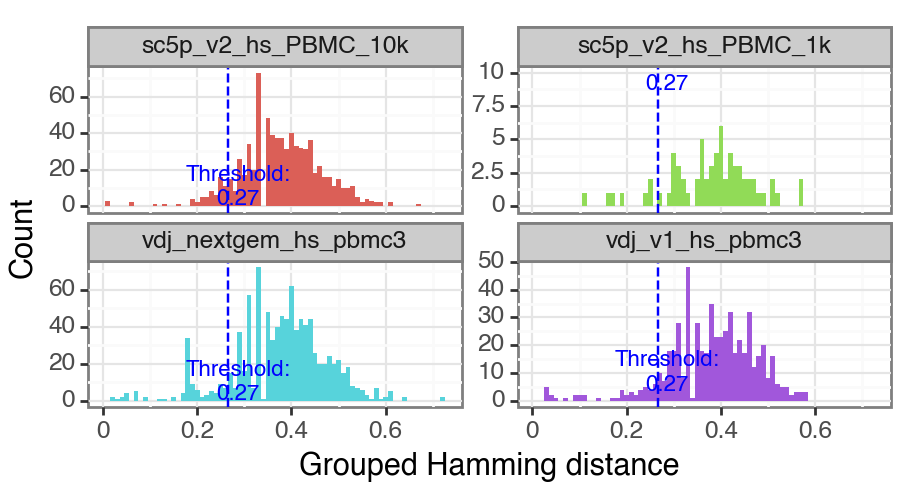


 finished: Updated Dandelion object: 
   'threshold', threshold value for tuning clonal assignment
 (0:01:19)


In [8]:
ddl.pp.calculate_threshold(vdj)

In [9]:
# see the actual value in .threshold slot
vdj.threshold

np.float64(0.2661271213659882)

You can also manually select a value as the threshold if you wish. Note that rerunning this with `manual_threshold` is just for reproducing the plot but with the line at 0.1 in this tutorial. You can just edit `vdj.threshold` directly if you wish, i.e. `vdj.threshold = 0.1`.

Calculating threshold


R[write to console]: Error in (function (db, sequenceColumn = "junction", vCallColumn = "v_call",  : 
  361 cell(s) with multiple heavy chains found. One heavy chain per cell is expected.



Rerun this after filtering. For now, switching to heavy mode.


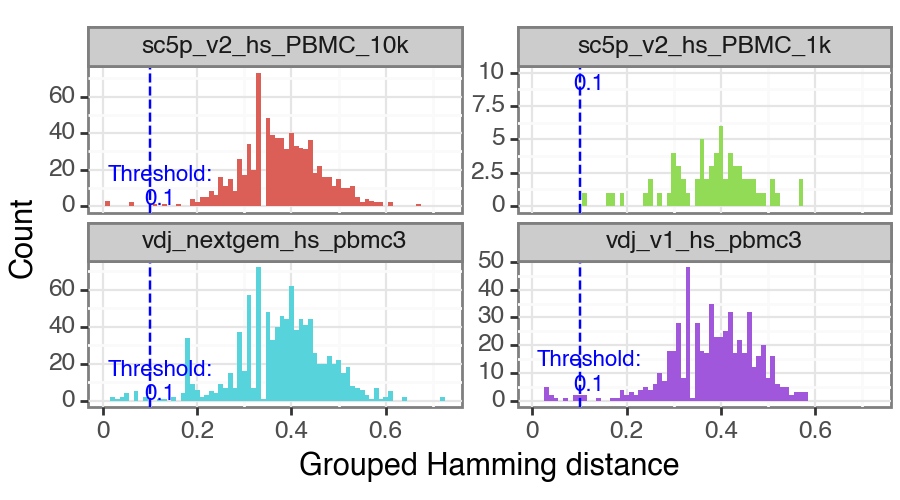


 finished: Updated Dandelion object: 
   'threshold', threshold value for tuning clonal assignment
 (0:00:05)


In [10]:
ddl.pp.calculate_threshold(vdj, manual_threshold=0.1)

In [11]:
# see the updated .threshold slot
vdj.threshold

0.1


We can run `ddl.tl.define_clones` to call *changeo's* `DefineClones.py`; see [here](https://changeo.readthedocs.io/en/stable/methods/clustering.html) for more info. Note, if a `pandas.DataFrame` or file path is provided as the input, the value in dist option (corresponds to threshold value) needs to be manually supplied. If a `Dandelion` object is provided, it will automatically retrieve it from the threshold slot. Additional options for `ddl.tl.define_clones` to provide to `DefineClones.py` can be supplied as a list to the `additional_args` option.

In [12]:
ddl.tl.define_clones(vdj, key_added="changeo_clone_id")
vdj

Finding clones
Running command: DefineClones.py -d /var/folders/_r/j_8_fj3x28n2th3ch0ckn9c40000gt/T/tmprlup1f2m/tmp/dandelion_define_clones_heavy-clone.tsv -o /var/folders/_r/j_8_fj3x28n2th3ch0ckn9c40000gt/T/tmprlup1f2m/dandelion_define_clones_heavy-clone.tsv --act set --model ham --norm len --dist 0.1 --nproc 1 --vf v_call_genotyped

       START> DefineClones
        FILE> dandelion_define_clones_heavy-clone.tsv
   SEQ_FIELD> junction
     V_FIELD> v_call_genotyped
     J_FIELD> j_call
 MAX_MISSING> 0
GROUP_FIELDS> None
      ACTION> set
        MODE> gene
    DISTANCE> 0.1
     LINKAGE> single
       MODEL> ham
        NORM> len
         SYM> avg
       NPROC> 1

PROGRESS> [Grouping sequences] 22:53:03 (2178) 0.0 min

PROGRESS> [Assigning clones] 22:53:06 |####################| 100% (2,178) 0.1 min

 OUTPUT> dandelion_define_clones_heavy-clone.tsv
 CLONES> 2119
RECORDS> 2178
   PASS> 2178
   FAIL> 0
    END> DefineClones

 finished: Updated Dandelion object: 
   'data', contig-index

Dandelion class object with n_obs = 2234 and n_contigs = 7357
    data: 'sequence_id', 'sequence', 'rev_comp', 'productive', 'v_call', 'd_call', 'j_call', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'v_cigar', 'd_cigar', 'j_cigar', 'stop_codon', 'vj_in_frame', 'locus', 'c_call', 'junction_length', 'np1_length', 'np2_length', 'v_sequence_start', 'v_sequence_end', 'v_germline_start', 'v_germline_end', 'd_sequence_start', 'd_sequence_end', 'd_germline_start', 'd_germline_end', 'j_sequence_start', 'j_sequence_end', 'j_germline_start', 'j_germline_end', 'v_score', 'v_identity', 'v_support', 'd_score', 'd_identity', 'd_support', 'j_score', 'j_identity', 'j_support', 'fwr1', 'fwr2', 'fwr3', 'fwr4', 'cdr1', 'cdr2', 'cdr3', 'cell_id', 'consensus_count', 'umi_count', 'v_call_10x', 'd_call_10x', 'j_call_10x', 'junction_10x', 'junction_10x_aa', 'j_support_igblastn', 'j_score_igblastn', 'j_call_igblastn', 'j_call_blastn', 'j_identity_blastn', 'j_alignment_length_blastn', 

Note that I specified the option `key_added` and this adds the output from `tl.define_clones` into a separate column. If left as default (`None`), it will write into `clone_id` column. The same option can be specified in `tl.find_clones` earlier.

## Generation of V(D)J network
*dandelion* generates a network to facilitate visualisation of results, inspired from [[Bashford-Rogers2013]](https://genome.cshlp.org/content/23/11/1874). This uses the full V(D)J contig sequences instead of just the junctional sequences to chart a tree-like network for each clone. The actual visualization will be achieved through `scanpy` later.

### `ddl.tl.generate_network`

First we need to generate the network. `ddl.tl.generate_network` will take a V(D)J table that has clones defined, specifically under the `'clone_id'` column. The default mode is to use amino acid sequences for constructing Levenshtein distance matrices, but can be toggled using the `key` option.

If you have a pre-processed table parsed from immcantation's [method](https://changeo.readthedocs.io/en/stable/examples/10x.html), or any other method as long as it's in a *AIRR* format, the table can be used as well.

You can specify the `clone_key` option for generating the network for the clone id definition of choice as long as it exists as a column in the `.data` slot.

Before proceeding, let's do a bit of subsetting. Here I want to remove the Orphan VJ cells (lacking BCR heavy chain i.e. VDJ information). Whether or not you want to do this is up to you. I'm doing this because I want to focus on the BCR heavy chain for now. You may elect to keep everything and that can be your starting point for further analysis.

In [13]:
vdj = vdj[
    vdj.metadata.chain_status.isin(
        ["Single pair", "Extra pair", "Extra pair-exception", "Orphan VDJ"]
    )
].copy()
vdj

Dandelion class object with n_obs = 2112 and n_contigs = 5053
    data: 'sequence_id', 'sequence', 'rev_comp', 'productive', 'v_call', 'd_call', 'j_call', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'v_cigar', 'd_cigar', 'j_cigar', 'stop_codon', 'vj_in_frame', 'locus', 'c_call', 'junction_length', 'np1_length', 'np2_length', 'v_sequence_start', 'v_sequence_end', 'v_germline_start', 'v_germline_end', 'd_sequence_start', 'd_sequence_end', 'd_germline_start', 'd_germline_end', 'j_sequence_start', 'j_sequence_end', 'j_germline_start', 'j_germline_end', 'v_score', 'v_identity', 'v_support', 'd_score', 'd_identity', 'd_support', 'j_score', 'j_identity', 'j_support', 'fwr1', 'fwr2', 'fwr3', 'fwr4', 'cdr1', 'cdr2', 'cdr3', 'cell_id', 'consensus_count', 'umi_count', 'v_call_10x', 'd_call_10x', 'j_call_10x', 'junction_10x', 'junction_10x_aa', 'j_support_igblastn', 'j_score_igblastn', 'j_call_igblastn', 'j_call_blastn', 'j_identity_blastn', 'j_alignment_length_blastn', 

In [14]:
ddl.tl.generate_network(vdj)

Generating network


Setting up data: 4424it [00:00, 6769.07it/s]
Linking edges : 100%|██████████| 2063/2063 [00:00<00:00, 56318.25it/s]


Computing network layout
Computing expanded network layout
 finished: Updated Dandelion object: 
   'data', contig-indexed AIRR table
   'metadata', cell-indexed observations table
   'layout', graph layout
   'graph', network constructed from distance matrices of VDJ- and VJ- chains (0:00:06)


In `dandelion` version `>=0.2.2`, the default `layout_method` is changed to `sfdp`, which is implemented through `graph-tool` [package](https://graph-tool.skewed.de/). This is significantly faster than the default modified Fruchterman-Reingold layout which while will work reasonably fast here, it will take quite a while when a lot of contigs are provided (>100k cells may take 1 hour). You can toggle this behaviour with:

```python
ddl.tl.generate_network(vdj, layout_method = 'mod_fr') # for the original
ddl.tl.generate_network(vdj, layout_method = 'sfdp') # for sfdp
```

<div class="alert alert-info">

Generating graph without layout

If you don't care for the layout and simply want access to the network/graph, you can do:
<br>
```python
ddl.tl.generate_network(vdj, compute_layout = False)
```
<br>
and use the networkx graphs in the graph slot and compute your own layout as you wish.

In previous versions of dandelion, it used to be possible to generate the entire distance matrix for every pair of cell but this functionality was removed because it was too time consuming. If you are after this, please reach out to me and we can try and see if we can reimplement it!
    
</div>

#### down sampling data/graph

You can also downsample the number of cells. This will return a new object as a downsampled copy of the original with its own distance matrix. We will add `use_existing_graph=False` for this to work (otherwise it will just reuse the previous graph to recompute a layout; it will throw an error as it doesn't know what to do with downsampling).

In [15]:
vdj_downsample = ddl.tl.generate_network(
    vdj, downsample=500, use_existing_graph=False
)
vdj_downsample

Generating network
Downsampling to 500 cells.


Setting up data: 1054it [00:00, 7901.76it/s]
Linking edges : 100%|██████████| 492/492 [00:00<00:00, 123716.88it/s]


Computing network layout
Computing expanded network layout
 finished: Updated Dandelion object: 
   'data', contig-indexed AIRR table
   'metadata', cell-indexed observations table
   'layout', graph layout
   'graph', network constructed from distance matrices of VDJ- and VJ- chains (0:00:01)


Dandelion class object with n_obs = 500 and n_contigs = 1054
    data: 'sequence_id', 'sequence', 'rev_comp', 'productive', 'v_call', 'd_call', 'j_call', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'v_cigar', 'd_cigar', 'j_cigar', 'stop_codon', 'vj_in_frame', 'locus', 'c_call', 'junction_length', 'np1_length', 'np2_length', 'v_sequence_start', 'v_sequence_end', 'v_germline_start', 'v_germline_end', 'd_sequence_start', 'd_sequence_end', 'd_germline_start', 'd_germline_end', 'j_sequence_start', 'j_sequence_end', 'j_germline_start', 'j_germline_end', 'v_score', 'v_identity', 'v_support', 'd_score', 'd_identity', 'd_support', 'j_score', 'j_identity', 'j_support', 'fwr1', 'fwr2', 'fwr3', 'fwr4', 'cdr1', 'cdr2', 'cdr3', 'cell_id', 'consensus_count', 'umi_count', 'v_call_10x', 'd_call_10x', 'j_call_10x', 'junction_10x', 'junction_10x_aa', 'j_support_igblastn', 'j_score_igblastn', 'j_call_igblastn', 'j_call_blastn', 'j_identity_blastn', 'j_alignment_length_blastn', '

<b>check the newly re-initialized Dandelion object</b>

In [16]:
vdj

Dandelion class object with n_obs = 2112 and n_contigs = 5053
    data: 'sequence_id', 'sequence', 'rev_comp', 'productive', 'v_call', 'd_call', 'j_call', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'v_cigar', 'd_cigar', 'j_cigar', 'stop_codon', 'vj_in_frame', 'locus', 'c_call', 'junction_length', 'np1_length', 'np2_length', 'v_sequence_start', 'v_sequence_end', 'v_germline_start', 'v_germline_end', 'd_sequence_start', 'd_sequence_end', 'd_germline_start', 'd_germline_end', 'j_sequence_start', 'j_sequence_end', 'j_germline_start', 'j_germline_end', 'v_score', 'v_identity', 'v_support', 'd_score', 'd_identity', 'd_support', 'j_score', 'j_identity', 'j_support', 'fwr1', 'fwr2', 'fwr3', 'fwr4', 'cdr1', 'cdr2', 'cdr3', 'cell_id', 'consensus_count', 'umi_count', 'v_call_10x', 'd_call_10x', 'j_call_10x', 'junction_10x', 'junction_10x_aa', 'j_support_igblastn', 'j_score_igblastn', 'j_call_igblastn', 'j_call_blastn', 'j_identity_blastn', 'j_alignment_length_blastn', 

The graph/networks can be accessed through the `.graph` slot as an [networkx](https://networkx.org/) graph object if you want to extract the data for network statistics or make any changes to the network.

At this point, we can save the dandelion object.

In [18]:
vdj.write_h5ddl("dandelion_results.h5ddl", compression="gzip")